# Dimensionality reduction with cisTopic

Using inline R magic

In [46]:
import anndata
import numpy as np
import scanpy as sc 
import pandas as pd

In [2]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 200, color_map = 'RdPu', dpi_save = 180, vector_friendly = True, format = 'svg')

-----
anndata     0.7.5
scanpy      1.6.0
sinfo       0.3.1
-----
PIL                 7.2.0
anndata             0.7.5
backcall            0.2.0
cairo               1.19.1
cffi                1.14.0
colorama            0.4.3
concurrent          NA
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.1
decorator           4.4.2
encodings           NA
genericpath         NA
get_version         2.1
h5py                2.10.0
igraph              0.7.1
ipykernel           5.3.4
ipython_genutils    0.2.0
jedi                0.17.2
joblib              0.17.0
kiwisolver          1.2.0
legacy_api_wrap     1.2
llvmlite            0.34.0
louvain             0.6.1
matplotlib          3.2.0
mkl                 2.3.0
mpl_toolkits        NA
natsort             7.0.1
ntpath              NA
numba               0.51.2
numexpr             2.7.1
numpy               1.19.1
opcode              NA
packaging           20.4
pandas              1.1.4
parso               0.7.0
pexpect        

### r2py set-up

In [3]:
import rpy2.rinterface_lib.callbacks
import logging

I use `anndata2ri` to handle conversion of the sparse matrix (not too straightforward with `rpy2` alone)

In [4]:
import anndata2ri
anndata2ri.activate()

Loading the `rpy2` extension enables cell magic to be used. This runs R code in jupyter notebook cells.

In [5]:
%load_ext rpy2.ipython

In [19]:
%%R

library(cisTopic)
library(Matrix)

### Load data

In [7]:
outdir = "/home/ubuntu/experiments/heart/scATACseq/ed6_pipeline/regions/LV/"
experiment_prefix = 'hca_heart_LV'

In [8]:
adata = sc.read_h5ad('/home/ubuntu/data/heart/scATACseq/cellatac/regions/LV-results200k/hca_heart_LV_ATAC_raw.h5ad')
adata

AnnData object with n_obs × n_vars = 10145 × 135228
    obs: 'cellatac_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'binary_raw'

### Set-up for cisTopic

Remove empty rows

In [9]:
adata = adata[:,adata.X.sum(0) > 0]
adata

View of AnnData object with n_obs × n_vars = 10145 × 135228
    obs: 'cellatac_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'binary_raw'

### Convert `anndata` object to `SingleCellExperiment` (conversion cab take a while)

In [12]:
%%R -i adata
adata

class: SingleCellExperiment 
dim: 135228 10145 
metadata(0):
assays(2): X binary_raw
rownames(135228): chr1:816981-817435 chr1:831286-831573 ...
  chrY:21841899-21842541 chrY:26359383-26360236
rowData names(15): peak_width exon ... total_counts log1p_total_counts
colnames(10145): 24-AAACGAATCAAACCCA-1 24-AAAGGATAGGCACTAG-1 ...
  42-TTTGTGTGTTCCTATT-1 42-TTTGTGTTCCGATGCG-1
colData names(9): cellatac_clusters n_genes_by_counts ...
  pct_counts_in_top_200_genes pct_counts_in_top_500_genes
reducedDimNames(0):
altExpNames(0):


### Train `cisTopic` models

- Initialize `cisTopic` object 

In [13]:
%%R 

cisTopicObject <- createcisTopicObject(
    assay(adata, "X"),
    project.name='ATAC_cisTopic')

cisTopicObject

An object of class cisTopic in project ATAC_cisTopic 
 135228 regions across 10145 samples.


- OBS: The option `options(future.globals.maxSize = 1000 * 1024^2)` adjust your R to fit your data in the available RAM. This setting should be changed according to the specs of your local machine. 

In [15]:
%%R -i outdir -i experiment_prefix
options(future.globals.maxSize = 1000 * 1024^2)

topics_vec <- c(1:30)
cisTopicObject <- runWarpLDAModels(cisTopicObject, topic = topics_vec, 
                                   seed = 1712, 
                                   nCores = 30, 
                                   iterations = 500
                                  )

[1] "Exporting data..."
[1] "Run models..."


- Save trained models

In [21]:
%%R 

saveRDS(cisTopicObject, paste0(outdir, experiment_prefix, "ATAC.trainedCistopic.RDS"))

- Read in `cisTopic` models

In [22]:
%%R -i outdir -i experiment_prefix

cisTopicObject <- readRDS(paste0(outdir, experiment_prefix, "ATAC.trainedCistopic.RDS"))

- Select model

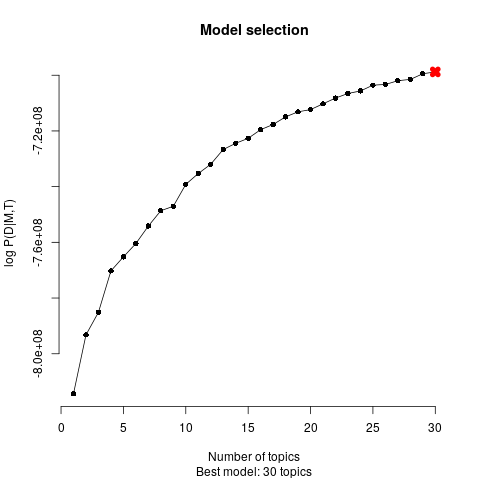

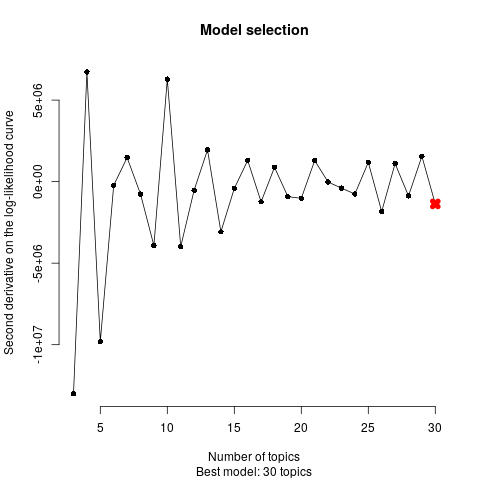

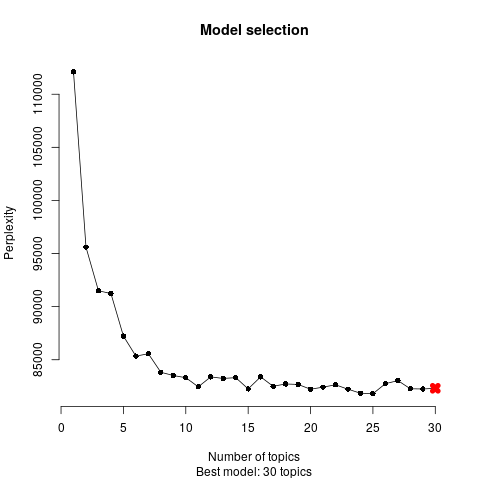

In [23]:
%%R

cistopic_model <- selectModel(cisTopicObject, type = "maximum")

- Save topic matrix

In [24]:
%%R -o topicXcell

topicXcell <- modelMatSelection(cistopic_model, 'cell', 'Probability')
dim(topicXcell)

[1]    30 10145


- Add `cisTopic` matrix to `anndata`

In [25]:
adata.obsm['X_cistopic'] = topicXcell.T

### Visualize dim reduction results

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:14)


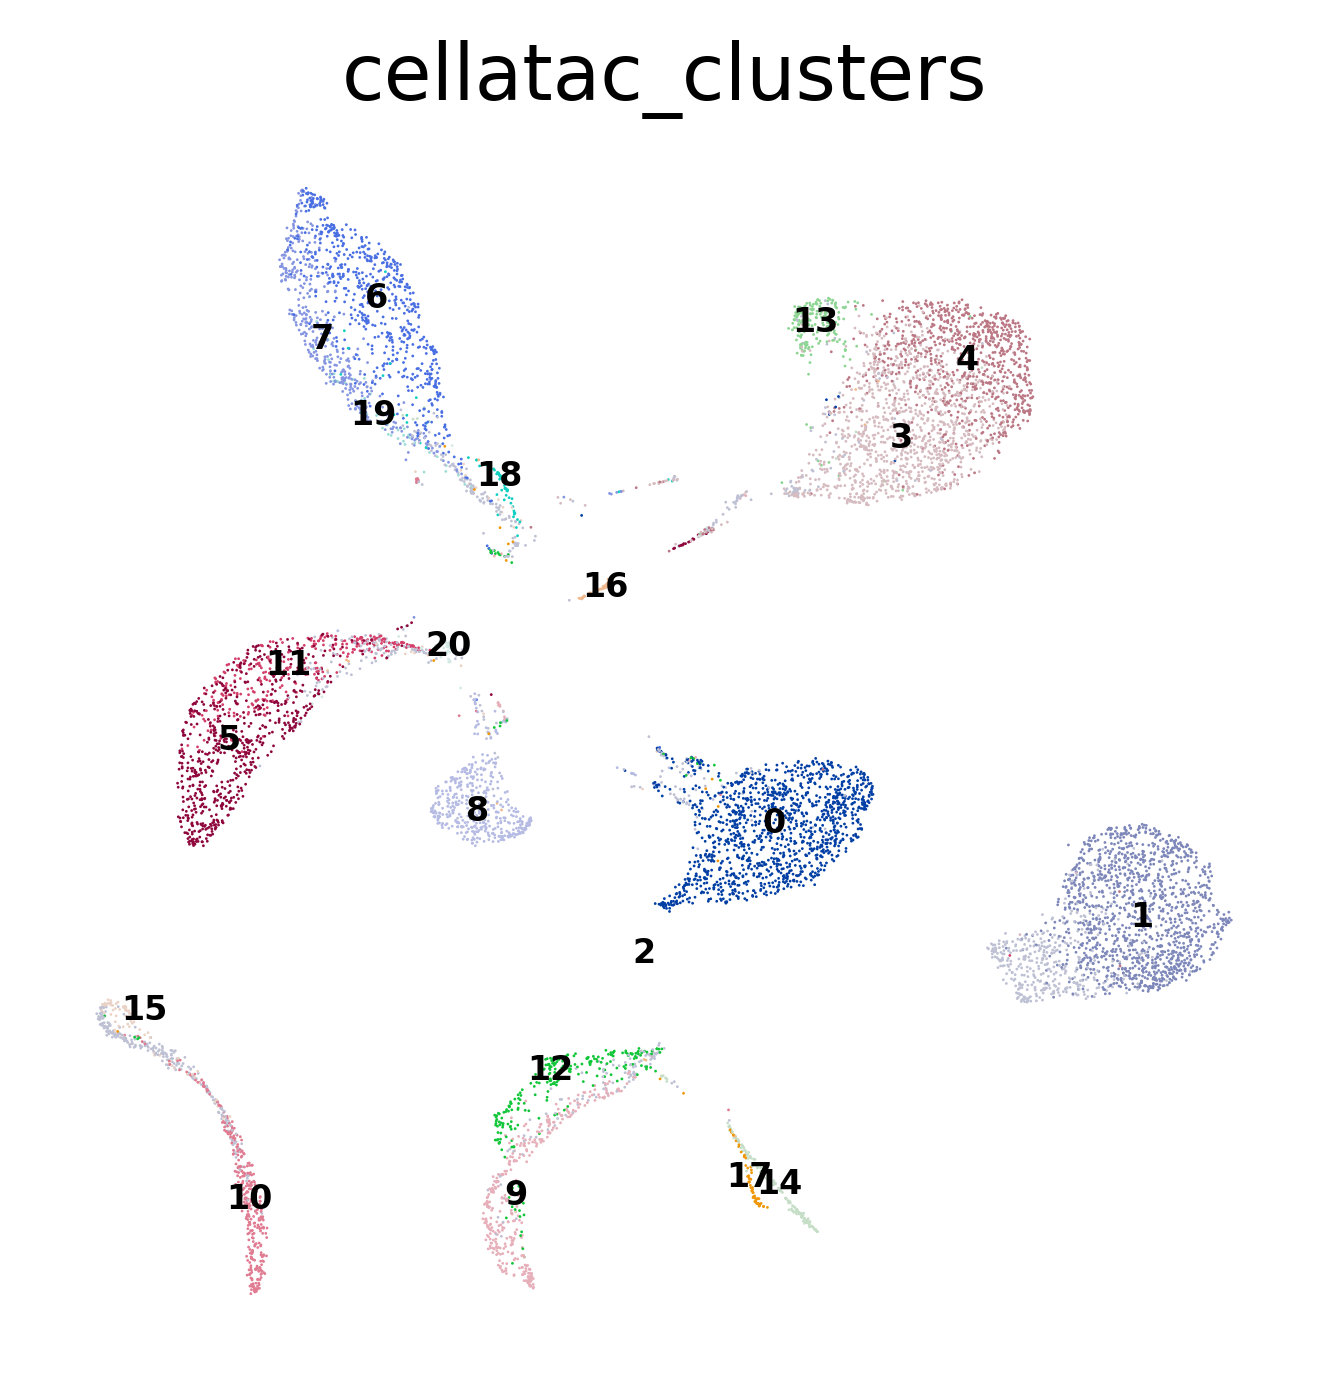

In [29]:
sc.pp.neighbors(adata, n_neighbors = 50, use_rep = "X_cistopic")
sc.tl.umap(adata, min_dist = 0.3, spread = 2)
adata.obs["cellatac_clusters"] = adata.obs["cellatac_clusters"].astype("category")
sc.pl.umap(adata, color = "cellatac_clusters", frameon = False, size = 1, legend_loc = 'on data', legend_fontsize = 6)

### De-noising the peak x cell matrix with cisTopic

The learnt LDA model from cisTopic can be used to generate a de-noised accessibility matrix. From the [paper](https://www.nature.com/articles/s41592-019-0367-1):

> cisTopic calculates the predictive distribution, which describes
the probability of each region in each cell, by multiplying the topic–cell and the
region–topic distributions:
$$
P(r_i|c_j) = \sum_{k=1}^{K}{P(r_i|T_k)P(T_k|c_j)}
$$
where
> - $P(r_i | c_j)$ is the probability of region i in cell j,
> - $P(r_i | T_k)$ is the probability of region i in topic k, and
> - $P(T_k | c_j)$ is the probability of topic k in cell j.


Export the region x topic probability matrix

In [30]:
%%R -o p_mat
p_mat <- predictiveDistribution(cistopic_model)

In [31]:
adata.layers["cistopic_p"] = p_mat.T

### Calculate de-noised gene scores

The de-noised accessibility signal can be used to calculate a gene-level accessibility scores (first implemented in [Bravo Gonzales-Blas et al. 2020](https://www.embopress.org/doi/full/10.15252/msb.20209438)). This is very useful to check out accessibility of marker genes for example. From the paper:

> we first multiply the region‐topic and topic‐cell distributions to obtain a region‐cell distribution, which indicates the probability of accessibility of each region in each cell. Then, for each gene, we aggregate the probabilities of the surrounding regions (in this case, 5 kb around the TSS plus introns), resulting in a gene activity score

At the moment there is no specific function in cisTopic to do this, but here is a simple implementation using functionality in `GenomicRanges` and `Signac`. Here I use peaks within a 5kb window of a gene (`d` parameter)

In [32]:
%%R 
library(GenomicRanges)
library(ensembldb)
library(EnsDb.Hsapiens.v86)
library(tidyr)

R[write to console]: Loading required package: GenomicFeatures

R[write to console]: Loading required package: AnnotationDbi

R[write to console]: Loading required package: AnnotationFilter

R[write to console]: 
Attaching package: 'ensembldb'


R[write to console]: The following object is masked from 'package:stats':

    filter


R[write to console]: 
Attaching package: 'tidyr'


R[write to console]: The following object is masked from 'package:S4Vectors':

    expand


R[write to console]: The following objects are masked from 'package:Matrix':

    expand, pack, unpack




### String - GRanges conversion

- Borrowed from Signac functions. See [here](https://satijalab.org/signac/reference/GRangesToString.html)

In [33]:
%%R

StringToGRanges <- function(regions, sep = c("-", "-"), ...) {
  ranges.df <- data.frame(ranges = regions)
  ranges.df <- separate(
    data = ranges.df,
    col = "ranges",
    sep = paste0(sep[[1]], "|", sep[[2]]),
    into = c("chr", "start", "end")
  )
  granges <- makeGRangesFromDataFrame(df = ranges.df, ...)
  return(granges)
}

GRangesToString <- function(grange, sep = c("-", "-")) {
  regions <- paste0(
    as.character(x = seqnames(x = grange)),
    sep[[1]],
    start(x = grange),
    sep[[2]],
    end(x = grange)
  )
  return(regions)
}

# Extend genomicRanges
# 
extend <- function(x, upstream=0, downstream=0)     
{
    if (any(strand(x) == "*"))
        warning("'*' ranges were treated as '+'")
    on_plus <- strand(x) == "+" | strand(x) == "*"
    new_start <- start(x) - ifelse(on_plus, upstream, downstream)
    new_end <- end(x) + ifelse(on_plus, downstream, upstream)
    ranges(x) <- IRanges(new_start, new_end)
    trim(x)
}


# Find peaks close to features of interest
#
# @param peaks_gr GenomicRanges object containing peaks
# @param features_gr GenomicRanges object containing features (e.g. genes)
# @param d distance to include peak, in bps (default 50000)
# @param feat_anno column in `features_gr@elementMetadata` containing annotation to name features (if NULL converts Granges to string)
#
# @return Sparse adjacency matrix indicating hits
peak2feature <- function(peaks_gr, features_gr, d=50000, feat_anno=NULL){
  seqlevelsStyle(features_gr) <- seqlevelsStyle(peaks_gr)
  
  ## Find peaks overlapping the search range around the features
  ext_gr <- extend(features_gr, upstream = d, downstream = d)
  ovs <- findOverlaps(peaks_gr, ext_gr)
  
  ## Define identifiers for peaks and features
  all_peaks <- GRangesToString(peaks_gr, sep = c(":", '-'))
  if (is.null(feat_anno)) {
    all_feats <- GRangesToString(features_gr, sep = c(":", '-'))
  } else {
    all_feats <- features_gr@elementMetadata[[feat_anno]]
  }
  
  ## Build adjacency matrix for hits
  adj_mat <- Matrix(data=0, nrow = length(all_peaks), ncol=length(all_feats))
  for (i in unique(subjectHits(ovs))) {
    # if (length(adj_mat[queryHits(ovs[subjectHits(ovs)==i]),i]) > 0) {
    adj_mat[queryHits(ovs[subjectHits(ovs)==i]),i] <- 1
    # }
  }
  colnames(adj_mat) <- all_feats
  rownames(adj_mat) <- all_peaks
  
  adj_mat
  
}

- And then we run the function

In [34]:
%%R
genes_gr <- genes(EnsDb.Hsapiens.v86)
peaks_gr <- StringToGRanges(rownames(p_mat), sep=c(":", "-"))

In [35]:
%%R -o gene_mat
## Compute peak2gene adjacency matrix
adj_mat <- peak2feature(peaks_gr, genes_gr, feat_anno = "gene_id", d = 5000)
# Filter genes with at least 3 peaks in the proximity
keep.genes <- which(colSums(adj_mat) > 2) 
gene_mat <- t(adj_mat[,keep.genes]) %*% p_mat
gene_mat <- as.matrix(t(gene_mat))

In [36]:
%%R -o gene_var
genes <- colnames(gene_mat)
gene_var <- genes_gr[genes,]@elementMetadata[c("gene_id","gene_name")]

Then you can save another anndata object with the same `.obs` as the original one, but storing the gene score info.

In [47]:
gene_adata = anndata.AnnData(X=gene_mat, 
                             obs=adata.obs, 
                             var=gene_var)
gene_adata.var_names = gene_adata.var["gene_name"]
gene_adata

/home/ubuntu/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 10145 × 13947
    obs: 'cellatac_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'gene_id', 'gene_name'

In [48]:
gene_adata.obs

,cellatac_clusters,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes
24-AAACGAATCAAACCCA-1,13,16808,9.729670,16808.0,9.729670,0.297477,0.594955,1.189910,2.974774
24-AAAGGATAGGCACTAG-1,4,10110,9.221379,10110.0,9.221379,0.494560,0.989120,1.978239,4.945598
24-AAAGGGCAGCGAGCTA-1,5,16764,9.727049,16764.0,9.727049,0.298258,0.596516,1.193033,2.982582
24-AAAGGGCAGTGATATG-1,14,4820,8.480737,4820.0,8.480737,1.037344,2.074689,4.149378,10.373444
24-AAATGAGTCCGGGCAT-1,13,22947,10.040986,22947.0,10.040986,0.217893,0.435787,0.871574,2.178934
...,...,...,...,...,...,...,...,...,...
42-TTTGTGTCAGCCACGT-1,6,2469,7.811973,2469.0,7.811974,2.025111,4.050223,8.100446,20.251114
42-TTTGTGTGTATCAGCT-1,0,13605,9.518266,13605.0,9.518266,0.367512,0.735024,1.470048,3.675119
42-TTTGTGTGTGGAAAGA-1,0,10312,9.241161,10312.0,9.241160,0.484872,0.969744,1.939488,4.848720
42-TTTGTGTGTTCCTATT-1,0,7458,8.917177,7458.0,8.917176,0.670421,1.340842,2.681684,6.704210


In [49]:
gene_adata.var

,gene_id,gene_name
gene_name,,
RP5-857K21.4,ENSG00000230021,RP5-857K21.4
LINC01128,ENSG00000228794,LINC01128
RP11-54O7.16,ENSG00000272438,RP11-54O7.16
RP11-54O7.3,ENSG00000223764,RP11-54O7.3
SAMD11,ENSG00000187634,SAMD11
...,...,...
F8,ENSG00000185010,F8
FUNDC2,ENSG00000165775,FUNDC2
PRKY,ENSG00000099725,PRKY


### Save anndata objects

In [50]:
gene_adata.write_loom("/home/ubuntu/experiments/heart/scATACseq/ed6_pipeline/regions/LV/hca_heart_LV_ATAC.geneScores.loom")

In [40]:
adata.write_h5ad(outdir + experiment_prefix + "_ATAC.wCisTopic.h5ad")